In [1]:
import wrds
import pandas as pd
import numpy as np
from scipy import stats
import scipy.linalg as la
from scipy.integrate import quad
from sklearn.metrics import make_scorer
from sklearn import linear_model
from sklearn import model_selection
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import linearmodels as lm
exec(open("/home/amz5/functionsByAnthony.py").read()) # do whatever is in functionsByAnthony.py
from statsmodels.iolib.summary2 import summary_col
import os
wd=os.getcwd()
import random

## Part 1 - No Skilled Funds

In [2]:
## Generating Time Series of Market returns (mkt_ts)
T=120
mu_rmktann=5
sigma_rmktann=20

np.random.seed(2021)

mkt_ts=np.random.normal(mu_rmktann/12,sigma_rmktann/np.sqrt(12),(T))

## Generating Time Series of Residuals (sig_ts)
#Changed from 30 to 10 following canvas announcement
res_vol_ann=10
N=1000
sig_ts=np.random.normal(0,res_vol_ann/np.sqrt(12),(N,T))

## Adding residuals to market returns to generate fund returns if alpha_i=0 for each fund
fundrets=sig_ts+mkt_ts

In [3]:
#Estimating each fund's alpha and its t-statistic and p-value 
tstats=[]
alphas=[]
pvals=[]
for n in range(0,N): 
    reg=sm.OLS(fundrets[n], sm.add_constant(mkt_ts)).fit()
    tstats.append(reg.tvalues[0])
    alphas.append(reg.params[0])
    pvals.append(reg.pvalues[0])
tstats=np.array(tstats)
alphas=np.array(alphas)
pvals=np.array(pvals)

**1. For each fund, estimate its alpha and t-statistic. How many funds are skilled at the 5% significance level based on t-statistics?**

In [4]:
pvals[(pvals<=.05)&(tstats>0)].shape

(22,)

I call funds skilled if they have statistically significant positive alphas.  Under this definition, 22 funds, or 2.2% appear to be skilled.

**2.  Plot the distributions of t-statistics and p-values for alpha.**

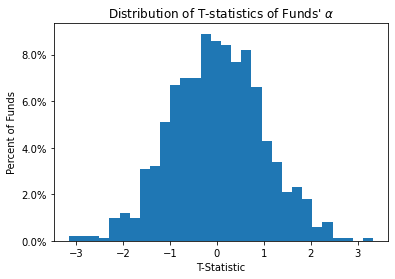

In [5]:
from matplotlib.ticker import PercentFormatter
## Plotting distribution of t-statistics
plot1=plt.figure()

plt.hist(tstats, bins=30, weights=np.ones(len(tstats)) / len(tstats))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("T-Statistic")
plt.ylabel("Percent of Funds")
plt.title("Distribution of T-statistics of Funds' $\\alpha$")

plt.show()

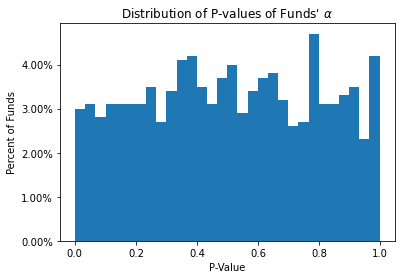

In [6]:
## Plotting distribution of p-values
plot2=plt.figure()

plt.hist(pvals, bins=30, weights=np.ones(len(pvals)) / len(pvals))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("P-Value")
plt.ylabel("Percent of Funds")
plt.title("Distribution of P-values of Funds' $\\alpha$")

plt.show()

**3. What does the distribution of p-values look like?**

The distribution of the p-values looks roughly uniform; the empirical density doesn't display a clear pattern and is more-or-less flat.

## Part 2 - Some Skilled Funds

I will simulate skilled funds by adding the appropriate $\alpha$ to the simulated returns in the previous part.

In [7]:
# Creating a function to find alphas, tstats, pvalues for each fund, given a proportion of skilled funds, llambda
def pre_plot(llambda):
    fundretsnew=fundrets.copy()
    #changed from 2.5 to 5 following canvas announcement
    alpha_yr=5
    alpha_mth=alpha_yr/12
    for n in range(0,int(N*llambda)): 
        fundretsnew[n]=fundrets[n]+alpha_mth
    
#Estimating each fund's alpha and its t-statistic and p-value 
    tstats=[]
    alphas=[]
    pvals=[]
    lam=[llambda]*N
    
    for n in range(0,N): 
        reg=sm.OLS(fundretsnew[n], sm.add_constant(mkt_ts)).fit()
        tstats.append(reg.tvalues[0])
        alphas.append(reg.params[0])
        pvals.append(reg.pvalues[0])
    tstats=np.array(tstats)
    alphas=np.array(alphas)
    pvals=np.array(pvals)
    lam=np.array(lam)
    
    return pd.DataFrame(data={'Fundno':np.array(range(0,N)), 'T-statistic':tstats, 'P-Value':pvals, 
                              '$\\alpha$':alphas, '$\\lambda$':lam})

In [8]:
lambda10=pre_plot(.1)
lambda25=pre_plot(.25)
lambda50=pre_plot(.5)
lambda75=pre_plot(.75)

**1. For each $\lambda$ value, make a plot of the cross-sectional distribution of estimated $\alpha$, their T-stats, and the p-values. How does the p-value distribution change with the fraction
of truly skilled funds?**

In [9]:
#Defining a function which plots the distributions of the alpha/Tstat/pvalue for each lambda
def plotr(var):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True)
    fig.suptitle('Distribution of Estimated '+var+', by $\\lambda$')
    ax1.hist(lambda10[var], bins=30, weights=100*np.ones(len(lambda10[var])) / len(lambda10[var]))
    ax1.set_title('$\\lambda$=.1')
    ax2.hist(lambda25[var], bins=30, weights=100*np.ones(len(lambda25[var])) / len(lambda25[var]))
    ax2.set_title('$\\lambda$=.25')
    ax3.hist(lambda50[var], bins=30, weights=100*np.ones(len(lambda50[var])) / len(lambda50[var]))
    ax3.set_title('$\\lambda$=.5')
    ax4.hist(lambda75[var], bins=30, weights=100*np.ones(len(lambda75[var])) / len(lambda75[var]))
    ax4.set_title('$\\lambda$=.75')
    plt.grid(False)
    fig.add_subplot(1, 1, 1, frame_on=False)

# Hiding the axis ticks and tick labels of the bigger plot
    plt.tick_params(labelcolor="none", bottom=False, left=False)

# Adding the x-axis and y-axis labels for the bigger plot
    plt.xlabel(var)
    plt.ylabel("Percent of Funds (%)")

    fig.tight_layout()
    fig.set_size_inches(10,7)
    return fig

<ipython-input-9-8838edfa466e>:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


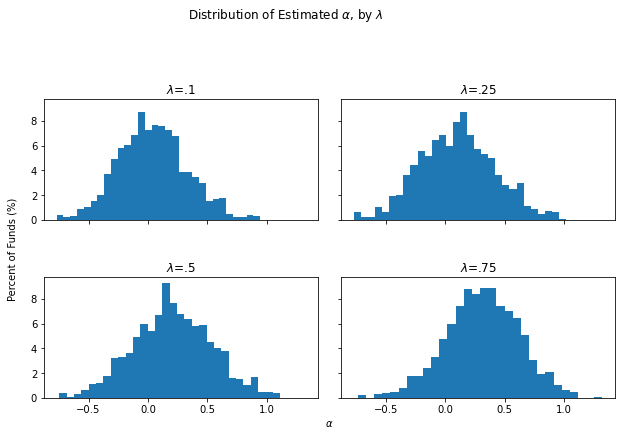

In [10]:
plot3=plotr("$\\alpha$")

<ipython-input-9-8838edfa466e>:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


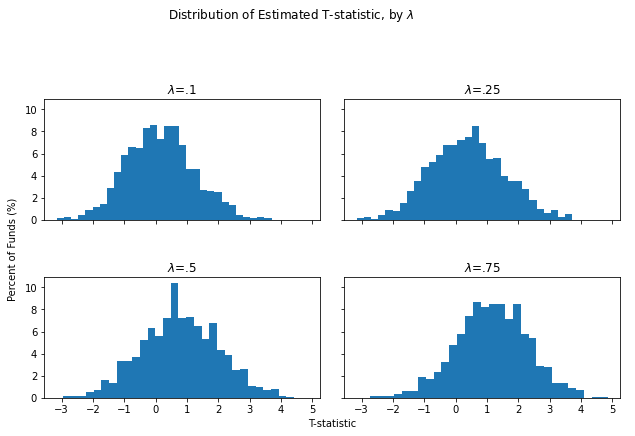

In [11]:
plot4=plotr("T-statistic")

<ipython-input-9-8838edfa466e>:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


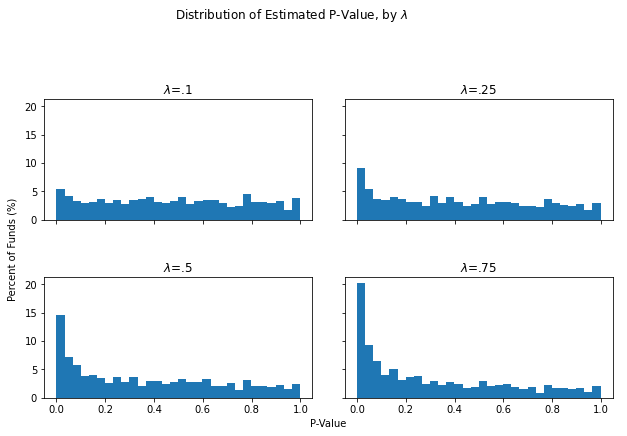

In [12]:
plot5=plotr("P-Value")

**2. How many of the truly skilled funds have insignificant alpha estimates? And how many
of the truly unskilled funds are identified as skilled based on significantly positive alpha
estimates? For each $\lambda$ value, report the percentage of funds in each classification**

In [13]:
#Defining a function to create a table similar to the one in the assignment for a given llambda
def conf_matrix(llambda):
    fundretsnew=fundrets.copy()
    alpha_yr=2.5
    alpha_mth=2.5/12
    for n in range(0,int(N*llambda)): 
        fundretsnew[n]=fundrets[n]+alpha_mth
    
#Estimating each fund's alpha and its t-statistic and p-value 
    tstats=[]
    alphas=[]
    pvals=[]
    for n in range(0,N): 
        reg=sm.OLS(fundretsnew[n], sm.add_constant(mkt_ts)).fit()
        tstats.append(reg.tvalues[0])
        alphas.append(reg.params[0])
        pvals.append(reg.pvalues[0])
    tstats=np.array(tstats)
    alphas=np.array(alphas)
    pvals=np.array(pvals)
    
    print("Lambda = ", str(llambda))
    alldat=pd.DataFrame(data={'Fundno':np.array(range(0,N)), 'tstat':tstats, 'pval':pvals, 'alpha':alphas})
    #Pairs are (True, Estimated)
    YY=alldat[(alldat["Fundno"]<llambda*N)&(alldat["pval"]<=.05)&(alldat["tstat"]>0)].shape[0]
    YN=alldat[(alldat["Fundno"]<llambda*N)&((alldat["pval"]>.05)|(alldat["tstat"]<0))].shape[0]
    NY=alldat[(alldat["Fundno"]>=llambda*N)&(alldat["pval"]<=.05)&(alldat["tstat"]>0)].shape[0]
    NN=alldat[(alldat["Fundno"]>=llambda*N)&((alldat["pval"]>.05)|(alldat["tstat"]<0))].shape[0]
    return pd.DataFrame(np.array([[100*YY/N, 100*YN/N], [100*NY/N,100*NN/N]]),
                  index=[["True Skill","True Skill"],['Y', 'N']],
                  columns=[["Estimated Skill","Estimated Skill"],['Y', 'N']])

In [14]:
t1=conf_matrix(.1)
t1

Lambda =  0.1


Estimated Skill      
                           Y     N
True Skill Y             0.9   9.1
           N             2.1  87.9

In [15]:
t2=conf_matrix(.25)
t2

Lambda =  0.25


Estimated Skill      
                           Y     N
True Skill Y             2.2  22.8
           N             1.9  73.1

In [16]:
t3=conf_matrix(.5)
t3

Lambda =  0.5


Estimated Skill      
                           Y     N
True Skill Y             5.6  44.4
           N             0.8  49.2

In [17]:
t4=conf_matrix(.75)
t4

Lambda =  0.75


Estimated Skill      
                           Y     N
True Skill Y             8.0  67.0
           N             0.4  24.6

That concludes the required analyses.  In the rest of the notebook I simply write the results to a latex file, using functions in ```'functionsByAnthony.py'```


//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [26]:
#Open the latex output file
tabcount=1
figcount=1
latexopen("PS1.tex", 1)

def ctab():
    global tabcount
    tabcount=tabcount+1
    return
def cfig():
    global figcount
    figcount=figcount+1
    return

latexwrite("PS1.tex",
"\\textbf{Part 1 - No Skilled Funds} \\\\", pure=True)

latexwrite("PS1.tex", "Figure "+str(figcount), "The figure below depicts the distribution of simulated T-statistics associated with alpha. "+
    "Alpha is estimated with simulated returns which are generated such that true alpha is equal to zero for each of 1000 funds/returns.")
latexplot(plot1, "PS1.tex", "plot1", '0cm', scale=.8)
cfig()
latexwrite("PS1.tex", "Figure "+str(figcount), "The figure below depicts the distribution of simulated p-values associated with alpha. "+
    "Alpha is estimated with simulated returns which are generated such that true alpha is equal to zero for each of 1000 funds/returns.")
latexplot(plot2, "PS1.tex", "plot2", '0cm', scale=.8)
cfig()

latexwrite("PS1.tex",
"\\textbf{Part 2 - Some Skilled Funds} \\\\", pure=True)
latexwrite("PS1.tex", "Figure "+str(figcount), "The figure below depicts the distribution of simulated alpha estimates. "+
    "Returns are simulated such that a fraction $\\lambda$ of the funds/returns are truly skilled ($\\alpha =5$\% per annum).")
latexplot(plot3, "PS1.tex", "plot3", '0cm', scale=.8)
cfig()
latexwrite("PS1.tex", "Figure "+str(figcount), "The figure below depicts the distribution of simulated T-statistics associated with alpha. "+
    "Returns are simulated such that a fraction $\\lambda$ of the funds/returns are truly skilled ($\\alpha =5$\% per annum).")
latexplot(plot4, "PS1.tex", "plot4", '0cm', scale=.8)
cfig()
latexwrite("PS1.tex", "Figure "+str(figcount), "The figure below depicts the distribution of simulated p-values associated with alpha. "+
    "Returns are simulated such that a fraction $\\lambda$ of the funds/returns are truly skilled ($\\alpha =5$\% per annum).")
latexplot(plot5, "PS1.tex", "plot5", '0cm', scale=.8)
cfig()

latexwrite("PS1.tex", "Tables 1-4", "The below tables display the perentage of funds falling into each true vs estimated skill "+
    "category. Returns are simulated such that a fraction $\\lambda$ of the funds/returns are truly skilled ($\\alpha =5$\% per annum).  "+
    "I am not sure why the tables are not appearing on the same page; I need to experiment with this more.")
latextable(t1,"PS1.tex", escape=False, newpage=False, title="Lambda=.1")
ctab()
#latexwrite("PS1.tex", "Lambda = .25", pure=True)
latextable(t2,"PS1.tex", escape=False, newpage=False, title="Lambda=.25")
ctab()
#latexwrite("PS1.tex", "Lambda = .5", pure=True)
latextable(t3,"PS1.tex", escape=False, newpage=False, title="Lambda=.5")
ctab()
#latexwrite("PS1.tex", "Lambda = .75", pure=True)
latextable(t4,"PS1.tex", escape=False, newpage=False, title="Lambda=.75")
ctab()

latexclose("PS1.tex")

#compile command: pdflatex -pdf PS1.tex